# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct, dayofmonth, month, current_date, isnan, count, when, desc, udf, col, sort_array, asc, avg, from_unixtime, datediff
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType

from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes,DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# load data
data = spark.read.json("mini_sparkify_event_data.json")
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
data.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [6]:
# explor null values of userId
data.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [7]:
# Drop the null strings + check
data = data.filter(data.userId != '')
# show number of recodrs data
data.describe().show(1, vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 278154 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 278154 
 lastName      | 278154 
 length        | 228108 
 level         | 278154 
 location      | 278154 
 method        | 278154 
 page          | 278154 
 registration  | 278154 
 sessionId     | 278154 
 song          | 228108 
 status        | 278154 
 ts            | 278154 
 userAgent     | 278154 
 userId        | 278154 
only showing top 1 row



In [8]:
data.select('sessionId').dropDuplicates().sort('sessionId').show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [9]:
# Let's see data for particler user
data.where("userId == 30").select(['userId','artist','page','song', 'level', 'userAgent']).collect()

[Row(userId='30', artist='Martha Tilston', page='NextSong', song='Rockpools', level='paid', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userId='30', artist='Adam Lambert', page='NextSong', song='Time For Miracles', level='paid', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userId='30', artist='Daft Punk', page='NextSong', song='Harder Better Faster Stronger', level='paid', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userId='30', artist='Starflyer 59', page='NextSong', song='Passengers (Old Album Version)', level='paid', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userId='30', artist=None, page='Add to Playlist', song=None, level='paid', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userId='30', artist='Frumpies', page='NextSong', song='Fuck Kitty', leve

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# Define Churn using SQL
data.createOrReplaceTempView('temp_view')

churn = spark.sql('SELECT DISTINCT userId, CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END AS is_churn FROM temp_view')

churn_pd = churn.toPandas()
churn_pd.groupby('is_churn', as_index=False).count()

,is_churn,userId
0,0,225
1,1,52


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [11]:
churn_data = data.join(churn, on='userId')
cleaned_data = churn_data.select(["userId", "is_churn"]).distinct().sort(["userId"])

### 1-  Length & itemInSession

In [12]:
# Avg total length per user
avlength = churn_data.groupBy('userId').avg('length')
avlength = avlength.withColumnRenamed("avg(length)", "avg_length")
length = churn_data.groupBy(['userId', 'is_churn']).avg('length')
cleaned_data = cleaned_data.join(length, on = 'userId', how = 'left')
avlength.show()

+------+------------------+
|userId|        avg_length|
+------+------------------+
|100010|  243.421444909091|
|200002|242.91699209302305|
|   125|261.13913749999995|
|   124|248.17653659965674|
|    51|247.88055082899055|
|     7| 253.5605806666668|
|    15|249.37701452978064|
|    54|250.38539934530067|
|   155| 242.4137706097561|
|100014| 263.4376345525293|
|   132|250.58034431535253|
|   154| 245.9526655952382|
|   101|249.00612947690533|
|    11| 246.7851051622872|
|   138|247.56032983574826|
|300017|  247.083419661344|
|100021|  250.579024521739|
|    29|   249.18017257926|
|    69|254.27913390222213|
|   112|246.80347251162797|
+------+------------------+
only showing top 20 rows



In [13]:
# Avg total length per churn
avg_length = churn_data.groupBy('is_churn').avg('length')
avg_length.show()

+--------+------------------+
|is_churn|       avg(length)|
+--------+------------------+
|       1|248.63279564406218|
|       0| 249.1171819778349|
+--------+------------------+



it seems there is no segnifent diffrece 

In [14]:
# Avg item length per session
itemInSession = churn_data.groupBy('is_churn').avg('itemInSession')
itemInSession.show()

+--------+------------------+
|is_churn|avg(itemInSession)|
+--------+------------------+
|       1|109.23299304564907|
|       0|114.89918174824018|
+--------+------------------+



it seems that users who cancel sub tend to spend less time in a session

### 2- Daily Session (new feature)

In [15]:
data2 = churn_data.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

data2 = data2.withColumn('day', dayofmonth('date')).withColumn('month', month('date'))

day_data = data2.groupBy(['userId', 'day']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)') \
                  .withColumnRenamed('avg(count(DISTINCT sessionId))', 'daily_sessions')

cleaned_data = cleaned_data.join(day_data, on='userId') 

In [16]:
Daily = cleaned_data.groupBy('userId').avg('daily_sessions')
Daily.show()
day_data.show()

+------+-------------------+
|userId|avg(daily_sessions)|
+------+-------------------+
|100010|                1.0|
|200002|                1.0|
|   125|                1.0|
|   124|               1.64|
|    51| 1.2307692307692308|
|     7|                1.0|
|    15| 1.2352941176470589|
|    54| 2.0416666666666665|
|   155|              1.125|
|100014|                1.2|
|   132| 1.2777777777777777|
|   154|                1.0|
|   101| 1.2307692307692308|
|    11| 1.2142857142857142|
|   138| 1.6666666666666667|
|300017|                2.4|
|100021|                1.2|
|    29| 1.8333333333333333|
|    69| 1.0909090909090908|
|   112| 1.4285714285714286|
+------+-------------------+
only showing top 20 rows

+------+------------------+
|userId|    daily_sessions|
+------+------------------+
|100010|               1.0|
|200002|               1.0|
|   125|               1.0|
|   124|              1.64|
|    51|1.2307692307692308|
|     7|               1.0|
|    15|1.2352941176470589

### 3- Gender per Churned

In [17]:
gender = churn_data.select(['userId', 'gender', 'is_churn']).distinct().groupBy(['is_churn','gender']).count().sort('is_churn')
gender = gender.withColumnRenamed("gender", "gender1")
gender.show()

+--------+-------+-----+
|is_churn|gender1|count|
+--------+-------+-----+
|       0|      M|  121|
|       0|      F|  104|
|       1|      F|   20|
|       1|      M|   32|
+--------+-------+-----+



In [19]:
# convert to dataframe to plot the data
gender_to_be_plotted = gender.toPandas()

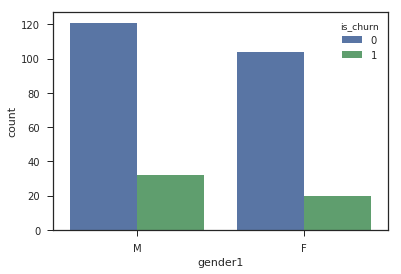

In [20]:
# plot data
sns.set(style="ticks")
sns.barplot(x="gender1", y="count", hue="is_churn", data=gender_to_be_plotted);

### 3- Level per Churned

In [21]:
level = churn_data.groupBy(['is_churn', 'level']).count()
level.show()

+--------+-----+------+
|is_churn|level| count|
+--------+-----+------+
|       0| free| 55721|
|       0| paid|222433|
|       1| paid| 32476|
|       1| free| 12388|
+--------+-----+------+



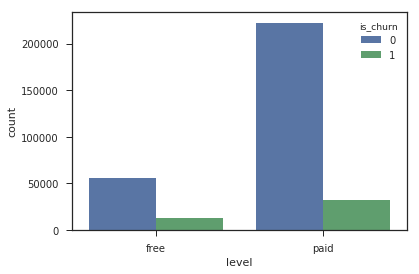

In [22]:
level_to_be_plotted = level.toPandas()
sns.set(style="ticks")
sns.barplot(x="level", y="count", hue="is_churn", data=level_to_be_plotted);

In [23]:
churn_data.groupBy(['is_churn', 'userAgent']).count().where(churn_data['is_churn'] == 0).sort(col('count').desc()).show(3)
churn_data.groupBy(['is_churn', 'userAgent']).count().where(churn_data['is_churn'] == 1).sort(col('count').desc()).show(3)

+--------+--------------------+-----+
|is_churn|           userAgent|count|
+--------+--------------------+-----+
|       0|"Mozilla/5.0 (Win...|22751|
|       0|"Mozilla/5.0 (Mac...|19611|
|       0|"Mozilla/5.0 (Mac...|18448|
+--------+--------------------+-----+
only showing top 3 rows

+--------+--------------------+-----+
|is_churn|           userAgent|count|
+--------+--------------------+-----+
|       1|"Mozilla/5.0 (Mac...| 4736|
|       1|"Mozilla/5.0 (Win...| 4525|
|       1|Mozilla/5.0 (Wind...| 3437|
+--------+--------------------+-----+
only showing top 3 rows



### 4- number of songs per session (new feature)

In [24]:
session_songs = churn_data.filter(churn_data.page=="NextSong").groupby("userId", "sessionId").count()
avg_session_songs = session_songs.groupby("userId").agg(avg(session_songs["count"]).alias("avgSessionSongs")).sort("userId")
avg_session_songs.show(3)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|              66.5|
+------+------------------+
only showing top 3 rows



### 5- Mapping level & gender

In [25]:
mapped_gender = churn_data.select("userId", "gender").dropDuplicates()
mapped_gender = mapped_gender.replace(["M", "F"], ["0", "1"], "gender")
mapped_gender = mapped_gender.withColumnRenamed("gender", "gender1")
mapped_gender = mapped_gender.select("userId", mapped_gender.gender1.cast("int"))


In [26]:
mapped_gender.show(3)

+------+-------+
|userId|gender1|
+------+-------+
|100010|      1|
|200002|      0|
|   125|      0|
+------+-------+
only showing top 3 rows



In [27]:
mapped_level = churn_data.select("userId", "level").dropDuplicates()
mapped_level = mapped_level.replace(["free", "paid"], ["0", "1"], "level")
mapped_level = mapped_level.select("userId", mapped_level.level.cast("int"))

### 7- page vists (new feature)

+--------+--------------------+------+
|is_churn|                page| count|
+--------+--------------------+------+
|       0|       Save Settings|   310|
|       1|              Logout|   553|
|       0|    Submit Downgrade|    63|
|       0|            NextSong|228108|
|       1|       Save Settings|    58|
|       0|          Add Friend|  4277|
|       1|         Roll Advert|   967|
|       0|               Error|   252|
|       0|     Add to Playlist|  6526|
|       0|               About|   495|
|       1|            Settings|   270|
|       1|      Submit Upgrade|    32|
|       0|           Thumbs Up| 12551|
|       1|Cancellation Conf...|    52|
|       1|     Add to Playlist|  1038|
|       1|            NextSong| 36394|
|       1|                Home|  1672|
|       1|             Upgrade|   112|
|       0|         Thumbs Down|  2546|
|       1|    Submit Downgrade|     9|
|       1|                Help|   239|
|       1|          Add Friend|   636|
|       0|               

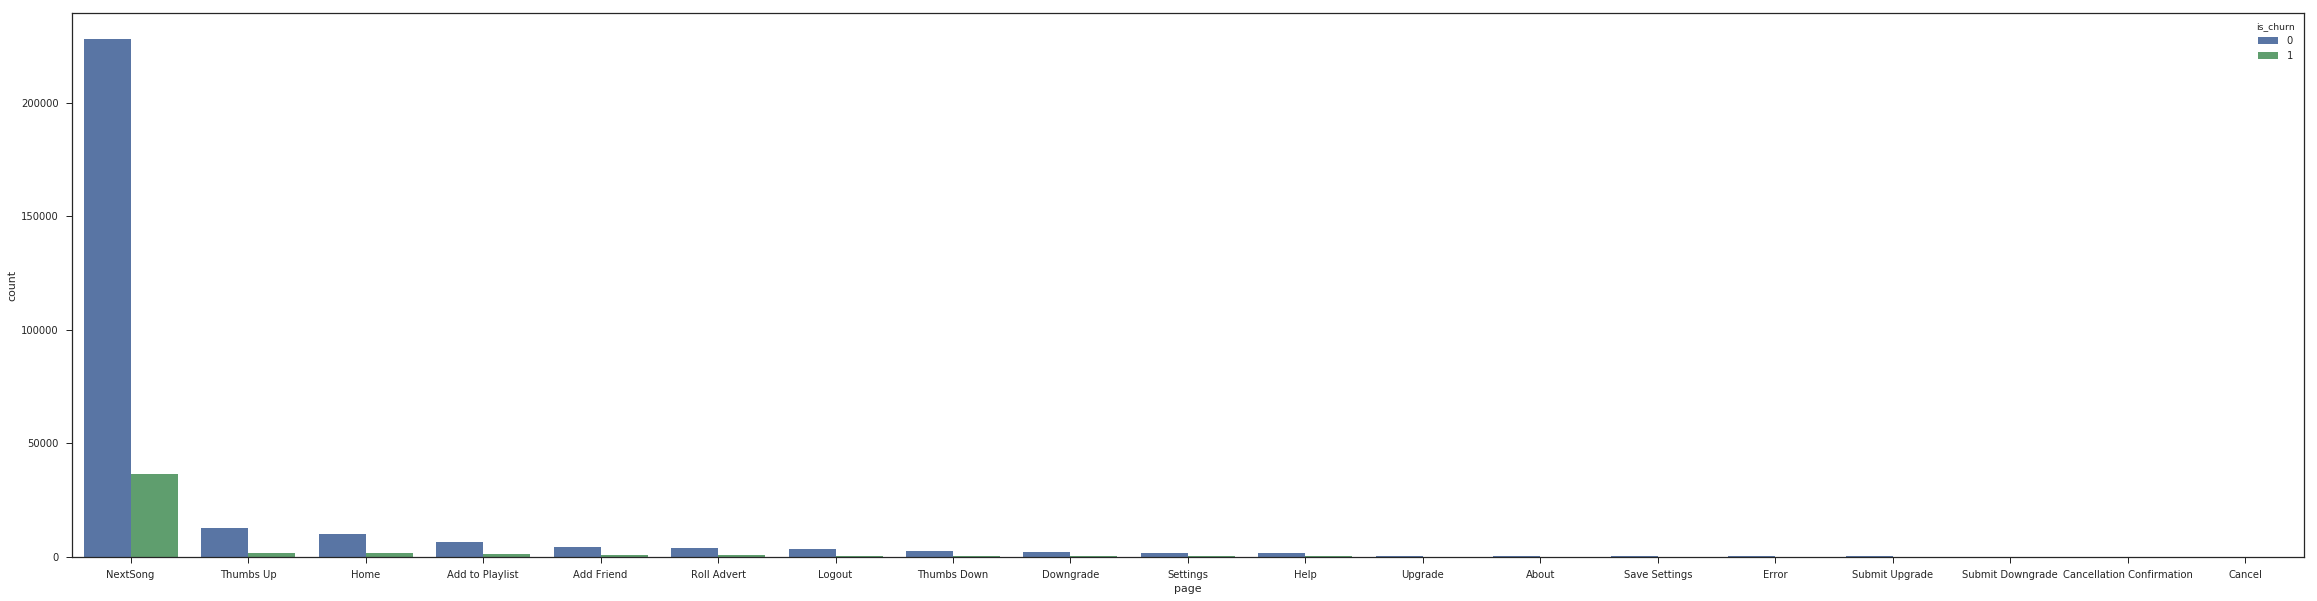

In [28]:
page = churn_data.groupBy(['is_churn', 'page']).count()
page.show(50)

page_to_be_plotted = page.toPandas().sort_values('count', ascending=False)
# sns.set(style="ticks")
f, ax = plt.subplots(figsize=(40, 10))
ax = sns.barplot(x='page', y="count", hue="is_churn", data=page_to_be_plotted )

In [29]:
list_pages = [(row['page']) for row in churn_data.select("page").dropDuplicates().collect()]

list_pages.remove("Cancel")
list_pages.remove("Cancellation Confirmation")

pages_view_total = churn_data.groupby("userId").count()
pages_view_total = pages_view_total.withColumnRenamed("count", "pageTotal")


for p in list_pages:
    col_name = "count" + p.replace(" ", "")
    view_count = churn_data.filter(churn_data.page==p).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    pages_view_total = pages_view_total.join(view_count, pages_view_total.userId==view_count.userIdTemp, "left").drop("userIdTemp")
pages_view_total = pages_view_total.sort("userId")
pages_view_total = pages_view_total.fillna(0)

In [30]:
cols = pages_view_total.columns
cols.remove("userId")
cols.remove("pageTotal")

freq_sql = "select userId"
for col in cols:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageTotal/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from pages_view_total"

pages_view_total.createOrReplaceTempView("pages_view_total")
cols = pages_view_total.columns
cols.remove("userId")
cols.remove("pageTotal")
freq_sql = "select userId"
for col in cols:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageTotal/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from pages_view_total"

user_pages_view_total = spark.sql(freq_sql)

In [31]:
user_pages_view_total.show(3)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+----------------

In [32]:
churn_data = churn_data.select("userId", "is_churn").dropDuplicates()
churn_data = churn_data.select("userId", churn_data.is_churn.cast("int"))

In [33]:
features = []
features.append(avlength)
features.append(day_data)
#avg_session_songs
features.append(avg_session_songs)
features.append(mapped_gender)
features.append(mapped_level)
features.append(user_pages_view_total)
features.append(churn_data)

In [34]:
final_dataset = churn_data.select("userId").dropDuplicates()

In [35]:
# maps features
for feature in features:
    feature = feature.withColumnRenamed("userId", "userIdTemp")
    final_dataset = final_dataset.join(feature, final_dataset.userId == feature.userIdTemp, "left").drop("userIdTemp")

In [36]:
final_dataset = final_dataset.sort("userId")
final_dataset.persist()
final_dataset.describe()

DataFrame[summary: string, userId: string, avg_length: string, daily_sessions: string, avgSessionSongs: string, gender1: string, level: string, freqSubmitDowngrade: string, freqThumbsDown: string, freqHome: string, freqDowngrade: string, freqRollAdvert: string, freqLogout: string, freqSaveSettings: string, freqAbout: string, freqSettings: string, freqAddtoPlaylist: string, freqAddFriend: string, freqNextSong: string, freqThumbsUp: string, freqHelp: string, freqUpgrade: string, freqError: string, freqSubmitUpgrade: string, is_churn: string]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [37]:
features_list = final_dataset.columns[1:]
for feat in features_list:
    f_name = feat + "Num"
    final_dataset = final_dataset.withColumn(f_name, final_dataset[feat].cast("float"))
    final_dataset = final_dataset.drop(feat)

In [38]:
final_dataset.describe()

DataFrame[summary: string, userId: string, avg_lengthNum: string, daily_sessionsNum: string, avgSessionSongsNum: string, gender1Num: string, levelNum: string, freqSubmitDowngradeNum: string, freqThumbsDownNum: string, freqHomeNum: string, freqDowngradeNum: string, freqRollAdvertNum: string, freqLogoutNum: string, freqSaveSettingsNum: string, freqAboutNum: string, freqSettingsNum: string, freqAddtoPlaylistNum: string, freqAddFriendNum: string, freqNextSongNum: string, freqThumbsUpNum: string, freqHelpNum: string, freqUpgradeNum: string, freqErrorNum: string, freqSubmitUpgradeNum: string, is_churnNum: string]

In [39]:
assembler = VectorAssembler(inputCols=final_dataset.columns[1:-1], outputCol="NumFeatures")
data3 = assembler.transform(final_dataset)

In [40]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data3)
data3 = scalerModel.transform(data3)

In [41]:
data3 = data3.select(data3.is_churnNum.alias("label"), data3.ScaledNumFeatures.alias("features"))

In [42]:
train, test = data3.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [43]:
train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   77|
|  0.0|   88|
+-----+-----+



In [52]:
# ======= model num 1 ======
model1 =  RandomForestClassifier(numTrees = 40, featureSubsetStrategy='auto')

paramGrid = ParamGridBuilder().build()

crossval1 = CrossValidator(estimator=model1,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

model1_fitted = crossval1.fit(train)

In [45]:
# ======= model num 2 ======
model2 = DecisionTreeClassifier()

paramGrid = ParamGridBuilder().build()

crossval2 = CrossValidator(estimator=model2,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

model2_fitted = crossval2.fit(train)

In [46]:
# ======= model num 3 ======

model3 = NaiveBayes()

paramGrid = ParamGridBuilder().build()

crossval3 = CrossValidator(estimator=model3,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

model3_fitted = crossval3.fit(train)

In [47]:
def getF1(model, metric, data):

    # predictions
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(data)
    
    # get score
    toBeCalculated = evaluator.evaluate(predictions)
    matrix = (predictions.groupby("label")
                                   .pivot("prediction")
                                   .count()
                                   .toPandas())
    
    return [toBeCalculated, matrix]

In [53]:
# f1 of model 1
model1_f1, model1_mtx = getF1(model1_fitted, 'f1', test)
print('F1 score of model #1:', model1_f1)
model1_mtx

F1 score of model #1: 0.6875


,label,0.0,1.0
0,1.0,4,1
1,0.0,19,6


In [49]:
model2_f1, model2_mtx = getF1(model2_fitted, 'f1', test)
print('F1 score of model #2:', model2_f1)
model2_mtx

F1 score of model #2: 0.5555555555555555


,label,0.0,1.0
0,1.0,5,NaN
1,0.0,15,10.0


In [50]:
model3_f1, model3_mtx = getF1(model3_fitted, 'f1', test)
print('F1 score of model #3:', model3_f1)
model3_mtx

F1 score of model #3: 0.7250409165302782


,label,0.0,1.0
0,1.0,3,2
1,0.0,19,6


By using three engineered features and based on the f1 value, the recommended model in my point of you is “Naive Bayes” due to the fact that it has the highest f1 score.
I’d suggest playing around with the model coefficients to achieve the highest score.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### Source
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#gradient-boosted-tree-classifier
https://www.kaggle.com/yukinagae/sparkify-project-churn-prediction
https://github.com/beefupinetree/dsnd-sparkify/blob/master/sparkify_local.ipynb
